In [1]:
import findspark

In [2]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import  KMeans
from pyspark.sql import SQLContext
import pandas as pd
import glob
import yaml
import csv
import numpy as np

In [3]:
spark = SparkSession.builder.appName('predict_outcome').getOrCreate()
df = spark.read .format("csv").option("header", "true").load("matches.csv")

In [4]:
df.show(5)

+---+------+---------+----------+--------------------+--------------------+--------------------+-------------+------+----------+--------------------+-----------+--------------+---------------+--------------------+--------------+-------------+-------+
| id|season|     city|      date|               team1|               team2|         toss_winner|toss_decision|result|dl_applied|              winner|win_by_runs|win_by_wickets|player_of_match|               venue|       umpire1|      umpire2|umpire3|
+---+------+---------+----------+--------------------+--------------------+--------------------+-------------+------+----------+--------------------+-----------+--------------+---------------+--------------------+--------------+-------------+-------+
|  1|  2017|Hyderabad|2017-04-05| Sunrisers Hyderabad|Royal Challengers...|Royal Challengers...|        field|normal|         0| Sunrisers Hyderabad|         35|             0|   Yuvraj Singh|Rajiv Gandhi Inte...|   AY Dandekar|     NJ Llong|   nu

In [5]:
df.filter("winner is null").count()

3

In [6]:
df = df.na.fill("Draw", "winner")

In [7]:
matches = df.toPandas()

In [8]:
matches.replace(['Mumbai Indians','Kolkata Knight Riders','Royal Challengers Bangalore','Deccan Chargers','Chennai Super Kings',
                 'Rajasthan Royals','Delhi Daredevils','Gujarat Lions','Kings XI Punjab',
                 'Sunrisers Hyderabad','Rising Pune Supergiants','Rising Pune Supergiant','Kochi Tuskers Kerala','Pune Warriors']
                ,['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','RPS','KTK','PW'],inplace=True)

In [9]:
encode = {'team1': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13},
          'team2': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13},
          'toss_winner': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13},
          'winner': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13,'Draw':14}}

In [10]:
matches.replace(encode, inplace=True)
matches.head(2)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,10,3,3,field,normal,0,10,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,None
1,2,2017,Pune,2017-04-06,1,11,11,field,normal,0,11,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,None


In [11]:
matches[pd.isnull(matches['city'])]

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
461,462,2014,None,2014-04-19,1,3,3,field,normal,0,3,0,7,PA Patel,Dubai International Cricket Stadium,Aleem Dar,AK Chaudhary,None
462,463,2014,None,2014-04-19,2,7,2,bat,normal,0,7,0,4,JP Duminy,Dubai International Cricket Stadium,Aleem Dar,VA Kulkarni,None
466,467,2014,None,2014-04-23,5,6,6,field,normal,0,5,7,0,RA Jadeja,Dubai International Cricket Stadium,HDPK Dharmasena,RK Illingworth,None
468,469,2014,None,2014-04-25,10,7,10,bat,normal,0,10,4,0,AJ Finch,Dubai International Cricket Stadium,M Erasmus,S Ravi,None
469,470,2014,None,2014-04-25,1,5,1,bat,normal,0,5,0,7,MM Sharma,Dubai International Cricket Stadium,BF Bowden,M Erasmus,None
474,475,2014,None,2014-04-28,3,9,9,field,normal,0,9,0,5,Sandeep Sharma,Dubai International Cricket Stadium,BF Bowden,S Ravi,None
476,477,2014,None,2014-04-30,10,1,1,field,normal,0,10,15,0,B Kumar,Dubai International Cricket Stadium,HDPK Dharmasena,M Erasmus,None


In [12]:
matches['city'].fillna('Dubai',inplace=True)
matches.describe()

,team1,team2,toss_winner,winner
count,636.000000,636.000000,636.000000,636.000000
mean,5.540881,5.511006,5.371069,5.309748
std,3.329169,3.341677,3.293140,3.288726
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,2.000000,2.000000
50%,5.000000,5.000000,5.000000,5.000000
75%,9.000000,8.000000,7.250000,8.000000
max,13.000000,13.000000,13.000000,14.000000


In [13]:
dicVal = encode['winner']
print(dicVal['MI']) #key value
print(list(dicVal.keys())[list(dicVal.values()).index(1)])

1
MI


In [14]:
matches = matches[['team1','team2','city','toss_decision','toss_winner','venue','winner']]
matches.head(2)

,team1,team2,city,toss_decision,toss_winner,venue,winner
0,10,3,Hyderabad,field,3,"Rajiv Gandhi International Stadium, Uppal",10
1,1,11,Pune,field,11,Maharashtra Cricket Association Stadium,11


In [15]:
df = pd.DataFrame(matches)
df.describe()

,team1,team2,toss_winner,winner
count,636.000000,636.000000,636.000000,636.000000
mean,5.540881,5.511006,5.371069,5.309748
std,3.329169,3.341677,3.293140,3.288726
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,2.000000,2.000000
50%,5.000000,5.000000,5.000000,5.000000
75%,9.000000,8.000000,7.250000,8.000000
max,13.000000,13.000000,13.000000,14.000000


In [16]:
temp1=df['toss_winner'].value_counts(sort=True)
temp2=df['winner'].value_counts(sort=True)
#Mumbai won most toss and also most matches
print('No of toss winners by each team')
for idx, val in temp1.iteritems():
   print('{} -> {}'.format(list(dicVal.keys())[list(dicVal.values()).index(idx)],val))
print('No of match winners by each team')
for idx, val in temp2.iteritems():
   print('{} -> {}'.format(list(dicVal.keys())[list(dicVal.values()).index(idx)],val))

No of toss winners by each team
MI -> 85
KKR -> 78
DD -> 72
RCB -> 70
KXIP -> 68
CSK -> 66
RR -> 63
DC -> 43
SRH -> 35
PW -> 20
GL -> 15
RPS -> 13
KTK -> 8
No of match winners by each team
MI -> 92
CSK -> 79
KKR -> 77
RCB -> 73
KXIP -> 70
RR -> 63
DD -> 62
SRH -> 42
DC -> 29
RPS -> 15
GL -> 13
PW -> 12
KTK -> 6
Draw -> 3


In [17]:
#shows that Mumbai won most matches followed by Chennai
df['winner'].hist(bins=40)

Text(0.5, 1.0, 'Match winners')

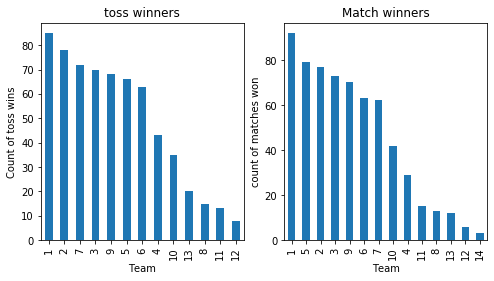

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Team')
ax1.set_ylabel('Count of toss wins')
ax1.set_title("toss winners")
temp1.plot(kind='bar')

ax2 = fig.add_subplot(122)
temp2.plot(kind = 'bar')
ax2.set_xlabel('Team')
ax2.set_ylabel('count of matches won')
ax2.set_title("Match winners")

In [19]:
 df.apply(lambda x: sum(x.isnull()),axis=0) 
    #find the null values in every column

team1            0
team2            0
city             0
toss_decision    0
toss_winner      0
venue            0
winner           0
dtype: int64

In [20]:
#Find cities which are null
df[pd.isnull(df['city'])]

,team1,team2,city,toss_decision,toss_winner,venue,winner


In [21]:
#building predictive model
from sklearn.preprocessing import LabelEncoder
var_mod = ['city','toss_decision','venue']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes 

team1            int64
team2            int64
city             int64
toss_decision    int64
toss_winner      int64
venue            int64
winner           int64
dtype: object

In [22]:
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
  model.fit(data[predictors],data[outcome])
  predictions = model.predict(data[predictors])
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print('Accuracy : %s' % '{0:.3%}'.format(accuracy))
  #kf = KFold(data.shape[0], n_splits=7)
  kf = KFold(n_splits=7)
  kf.get_n_splits(data)
  error = []
  for train, test in kf.split(data):
    train_predictors = (data[predictors].iloc[train,:])
    train_target = data[outcome].iloc[train]
    model.fit(train_predictors, train_target)
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
  print('Cross-Validation Score : %s' % '{0:.3%}'.format(np.mean(error)))

  model.fit(data[predictors],data[outcome]) 

In [23]:
from sklearn.ensemble import RandomForestRegressor
outcome_var=['winner']
predictor_var = ['team1','team2','toss_winner']
model = LogisticRegression()
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 23.270%
Cross-Validation Score : 21.852%


/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ammarpathan/anacond

In [24]:
df.head(3)

,team1,team2,city,toss_decision,toss_winner,venue,winner
0,10,3,14,1,3,23,10
1,1,11,25,1,11,16,11
2,8,2,27,1,2,25,2


In [25]:
model = RandomForestClassifier(n_estimators=100)
outcome_var = ['winner']
predictor_var = ['team1', 'team2', 'venue', 'toss_winner','city','toss_decision']
classification_model(model, df,predictor_var,outcome_var)

/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy : 89.151%


/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/ammarpathan/anaconda3/lib/python3.7/site-

Cross-Validation Score : 49.220%


/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [26]:
df.head(7)

,team1,team2,city,toss_decision,toss_winner,venue,winner
0,10,3,14,1,3,23,10
1,1,11,25,1,11,16,11
2,8,2,27,1,2,25,2
3,11,9,15,1,9,11,9
4,3,7,2,0,3,14,3
5,8,10,14,1,10,23,10
6,2,1,22,1,1,34,1


In [27]:
#'team1', 'team2', 'venue', 'toss_winner','city','toss_decision'
team1='RCB'
team2='KKR'
toss_winner='RCB'
input=[dicVal[team1],dicVal[team2],'14',dicVal[toss_winner],'2','1']
input = np.array(input).reshape((1, -1))
output=model.predict(input)
print(list(dicVal.keys())[list(dicVal.values()).index(output)]) #find key by value search output

KKR


In [28]:
#'team1', 'team2', 'venue', 'toss_winner','city','toss_decision'
team1='DC'
team2='DD'
toss_winner='DC'
input=[dicVal[team1],dicVal[team2],'23',dicVal[toss_winner],'14','0']
input = np.array(input).reshape((1, -1))
output=model.predict(input)
print(list(dicVal.keys())[list(dicVal.values()).index(output)]) #find key by value search output

DD


In [29]:
#feature importances: If we ignore teams, Venue seems to be one of important factors in determining winners 
#followed by toss winning, city
#we notice that team1 and team2 account for highest value for reason that it is either if these value 
#with toss winner going to be winner. So we could ignore team2 and team1
imp_input = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print(imp_input)

team2            0.252189
team1            0.224517
toss_winner      0.170131
venue            0.166501
city             0.152593
toss_decision    0.034070
dtype: float64


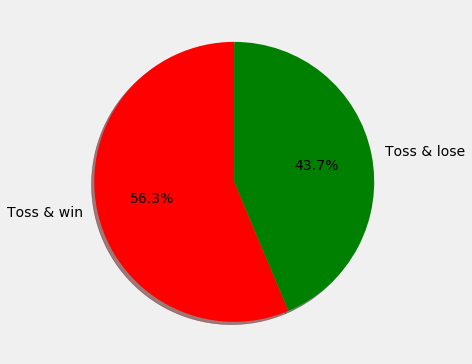

In [30]:
import matplotlib.pyplot as mlt
mlt.style.use('fivethirtyeight')
df_fil=df[df['toss_winner']==df['winner']]
slices=[len(df_fil),(577-len(df_fil))]
mlt.pie(slices,labels=['Toss & win','Toss & lose'],startangle=90,shadow=True,explode=(0,0),autopct='%1.1f%%',colors=['r','g'])
fig = mlt.gcf()
fig.set_size_inches(6,6)
mlt.show()

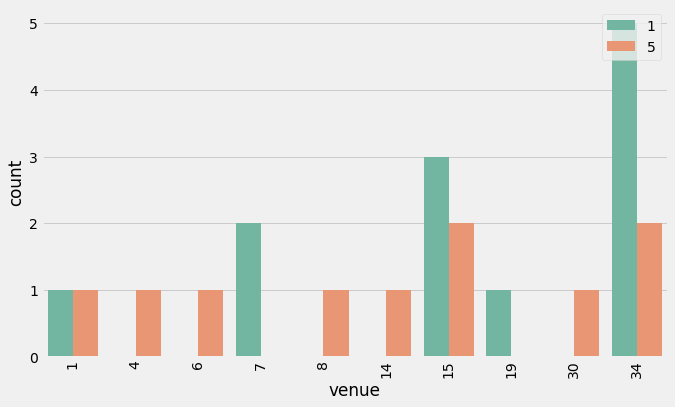

In [31]:
import seaborn as sns
team1=dicVal['MI']
team2=dicVal['CSK']
mtemp=matches[((matches['team1']==team1)|(matches['team2']==team1))&((matches['team1']==team2)|(matches['team2']==team2))]
sns.countplot(x='venue', hue='winner',data=mtemp,palette='Set2')
mlt.xticks(rotation='vertical')
leg = mlt.legend( loc = 'upper right')
fig=mlt.gcf()
fig.set_size_inches(10,6)
mlt.show()

In [32]:
le.classes_[34]

'Wankhede Stadium'

In [33]:
le.classes_[18]

'New Wanderers Stadium'

In [34]:
le.classes_[19]

'Newlands'

In [35]:
from sklearn.ensemble import AdaBoostClassifier

In [36]:
model = AdaBoostClassifier(n_estimators=100,random_state=0)
outcome_var = ['winner']
predictor_var = ['team1', 'team2', 'venue', 'toss_winner','city','toss_decision']
classification_model(model, df,predictor_var,outcome_var)

/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy : 19.811%


/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was e

Cross-Validation Score : 16.663%


/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
from sklearn.svm import LinearSVC

In [42]:
model = LinearSVC(random_state=0,tol=1e-5)
outcome_var = ['winner']
predictor_var = ['team1', 'team2', 'toss_winner','city']
classification_model(model, df,predictor_var,outcome_var)

/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy : 25.786%


/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users

Cross-Validation Score : 18.707%


/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [43]:
from sklearn.neural_network import MLPClassifier

In [45]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

In [46]:
outcome_var = ['winner']
predictor_var = ['team1', 'team2', 'venue', 'toss_winner','city','toss_decision']
classification_model(model, df,predictor_var,outcome_var)

/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy : 28.302%


/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.p

Cross-Validation Score : 25.154%


/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier

In [49]:
model = HistGradientBoostingClassifier()

In [50]:
outcome_var = ['winner']
predictor_var = ['team1', 'team2', 'venue', 'toss_winner','city','toss_decision']
classification_model(model, df,predictor_var,outcome_var)

/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy : 89.151%


/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was e

Cross-Validation Score : 54.251%


/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
